<a href="https://colab.research.google.com/github/asdacdsfca/DSC80/blob/main/PostgreSQL_Indexing_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install psycopg2-binary faker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.7 MB/s eta 0:00:00


**Install and setup PostgreSQL**

Warning: This notebook is designed to be run in a Google Colab only. It installs packages on the system and requires sudo access. If you want to run it in a local Jupyter notebook, please proceed with caution.

In order to demo the usage on Google Colab you will install PostgreSQL server. The password and an empty database is also needed.

If you are not running this notebook on Google Colab, or you prefer to use an existing database, please skip the following setup and proceed to the next section.

In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 10.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package cron.
(Reading database ... 122531 files and directories currently installed.)
Preparing to unpack .../0-cron_3.0pl1-136ubuntu1_amd64.deb ...
Unpacking cron (3.0pl1-136ubuntu1) ...
Selecting previously unselected package logrotate.
Preparing to unpack .../1-logrotate_3.14.0-4ubuntu3_amd64.deb ...
Unpacking logrotate (3.14.0-4ubuntu3) ...
Selecting previously unselected package netbase.
Preparing to unpack .../2-netbase_6.1_all.deb ...
Unpacking netbase (6.1) ...
Selecting previously unselected package pos

In [ ]:

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
# Setup a database with name `dsc100_demo_demo` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS dsc100_demo;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE dsc100_demo;'

ALTER ROLE
ERROR:  database "dsc100_demo" is being accessed by other users
DETAIL:  There is 1 other session using the database.
ERROR:  database "dsc100_demo" already exists


Setup necessary environmental variables

In [ ]:
%env TFIO_DEMO_DATABASE_NAME=tfio_demo
%env TFIO_DEMO_DATABASE_HOST=localhost
%env TFIO_DEMO_DATABASE_PORT=5432
%env TFIO_DEMO_DATABASE_USER=postgres
%env TFIO_DEMO_DATABASE_PASS=postgres

env: TFIO_DEMO_DATABASE_NAME=tfio_demo
env: TFIO_DEMO_DATABASE_HOST=localhost
env: TFIO_DEMO_DATABASE_PORT=5432
env: TFIO_DEMO_DATABASE_USER=postgres
env: TFIO_DEMO_DATABASE_PASS=postgres



Now, we need to establish a connection to the PostgreSQL database. 

In [ ]:
# Import necessary libraries
import psycopg2
from faker import Faker
import time
import pandas as pd
# Connect to your postgres DB

import psycopg2
conn = psycopg2.connect(
    dbname="dsc100_demo",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)



**Let's create a table and populate it with fake data.**

In [ ]:
# Open a cursor to perform database operations
cur = conn.cursor()
# Create a faker instance
fake = Faker()
# Create a new table
cur.execute("""
    CREATE TABLE IF NOT EXISTS people (
        id SERIAL PRIMARY KEY,
        name TEXT NOT NULL,
        income INTEGER NOT NULL
    );
""")

# Populate the table with a large amount of data
# Populate the table with a large amount of data
for _ in range(10000000):  # Adjust the number as needed
    cur.execute(
        "INSERT INTO people (name, income) VALUES (%s, %s)",
        (fake.name(), fake.random_int(min=20000, max=200000))
    )

conn.commit()

In [ ]:
cur.execute("SELECT * FROM people LIMIT 10")
rows = cur.fetchall()

for row in rows:
    print(row)

(1, 'Michelle Anderson', 66166, 0.45357734)
(2, 'Diane Phillips', 164637, 0.70582175)
(3, 'Brooke Green', 108043, 0.050003204)
(4, 'Kimberly Foley', 159029, 0.78460985)
(5, 'Robert Miller', 195392, 0.26985002)
(6, 'Michael Brown', 108232, 0.7824021)
(7, 'Alexander Wallace IV', 130749, 0.21107778)
(8, 'Anthony Shelton', 78693, 0.3413377)
(9, 'Rebecca Smith', 185519, 0.4027646)
(10, 'Courtney Cook', 66514, 0.46199083)


In [ ]:
cur.execute("SELECT count(*) FROM people")
rows = cur.fetchall()

for row in rows:
    print(row)

(80975,)


**Now, let's create a B-tree index and a hash index on the name field.**

In [ ]:
# Import necessary libraries
import psycopg2
from faker import Faker
import time
import pandas as pd

# Connect to your postgres DB
import psycopg2
conn = psycopg2.connect(
    dbname="dsc100_demo",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

# Open a cursor to perform database operations
cur = conn.cursor()

# Create a faker instance
fake = Faker()

# Execute the EXPLAIN query
cur.execute("EXPLAIN (ANALYZE, BUFFERS) SELECT * FROM people WHERE income > 10000")
# The above line executes an EXPLAIN query on the database, providing additional information
# about how the database engine plans to execute the SELECT statement.
# The ANALYZE keyword is used to include execution time information,
# and the BUFFERS keyword is used to include buffer usage information.

# Fetch and print the result
result = cur.fetchall()
# Fetch all the rows returned by the query and store them in the 'result' variable.

for row in result:
    print(row)
    # Iterate over each row in the result and print it.


('Seq Scan on people  (cost=0.00..1660.19 rows=80967 width=26) (actual time=0.008..9.212 rows=80975 loops=1)',)
('  Filter: (income > 10000)',)
('  Buffers: shared hit=648',)
('Planning Time: 0.245 ms',)
('Execution Time: 12.958 ms',)


Execution time for Point Query without an index: 1197.2477999999999
Execution time for Range Query without an index: 1054.1849
Execution time for Complex Query without an index: 1263.4987999999998
Execution time for Point Query with an index: 0.07620000000000002
Execution time for Range Query with an index: 0.7510000000000001
Execution time for Complex Query with an index: 0.019100000000000006
Performance improvement ratio for Point Query due to indexing: 15711.913385826767
Performance improvement ratio for Range Query due to indexing: 1403.7082556591208
Performance improvement ratio for Complex Query due to indexing: 66151.76963350782


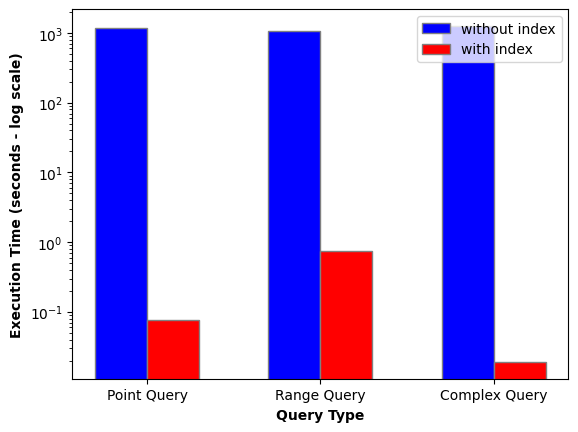

In [ ]:
# Function to calculate execution time for a query with multiple runs
def calculate_average_execution_time(cur, query, num_executions=10):
    total_time = 0
    for _ in range(num_executions):
        total_time += calculate_execution_time(cur, query)
    return total_time / num_executions

# Disable indexes and enable sequential scan
cur.execute("SET enable_seqscan = ON")
cur.execute("SET enable_indexscan = OFF")
cur.execute("SET enable_bitmapscan = OFF")


# Queries
# Modify the value of 199990 to experiment with the output size and observe the changes in trends!
queries = [
    "SELECT * FROM people WHERE name = 'John'",
    "SELECT * FROM people WHERE income > 199990",
    "SELECT * FROM people WHERE name = 'John' AND income > 199990"
]

# Query names for printing and plotting
query_names = ['Point Query', 'Range Query', 'Complex Query']

# Execution times without index
times_without_index = [calculate_average_execution_time(cur, query) for query in queries]

# Print execution times without index
for name, time in zip(query_names, times_without_index):
    print(f"Execution time for {name} without an index: {time}")

# Create indexes
#cur.execute("CREATE INDEX idx_people_income ON people USING btree  (income)")
#cur.execute("CREATE INDEX idx_people_name ON people USING hash (name)")
#cur.execute("CREATE INDEX idx_people_name_income2 ON people(name, income)")

# Enable indexes and disable sequential scan
cur.execute("SET enable_seqscan = OFF")
cur.execute("SET enable_indexscan = ON")
cur.execute("SET enable_bitmapscan = ON")


# Execution times with index
times_with_index = [calculate_average_execution_time(cur, query) for query in queries]

# Print execution times with index
for name, time in zip(query_names, times_with_index):
    print(f"Execution time for {name} with an index: {time}")

# Calculate improvement ratios
improvement_ratios = [time_without / time_with for time_without, time_with in zip(times_without_index, times_with_index)]

# Print improvement ratios
for name, ratio in zip(query_names, improvement_ratios):
    print(f"Performance improvement ratio for {name} due to indexing: {ratio}")

# Plotting

# set width of bar
barWidth = 0.3

# Set position of bar on X axis
r1 = np.arange(len(times_without_index))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, times_without_index, color='b', width=barWidth, edgecolor='grey', label='without index')
plt.bar(r2, times_with_index, color='r', width=barWidth, edgecolor='grey', label='with index')

# Add xticks on the middle of the group bars
plt.xlabel('Query Type', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(times_without_index))], query_names)

# Create legend & Show graphic
plt.ylabel('Execution Time (seconds - log scale)', fontweight='bold')
plt.yscale('log')
plt.legend()
plt.show()

Average insertion time before indexes creation:  0.004384677410125732
Average deletion time before indexes creation:  1.1918126773834228
Average update time before indexes creation:  1.1947698712348938
Average insertion time after indexes creation:  0.0032062458992004393
Average deletion time after indexes creation:  0.0005511879920959472
Average update time after indexes creation:  0.000383760929107666


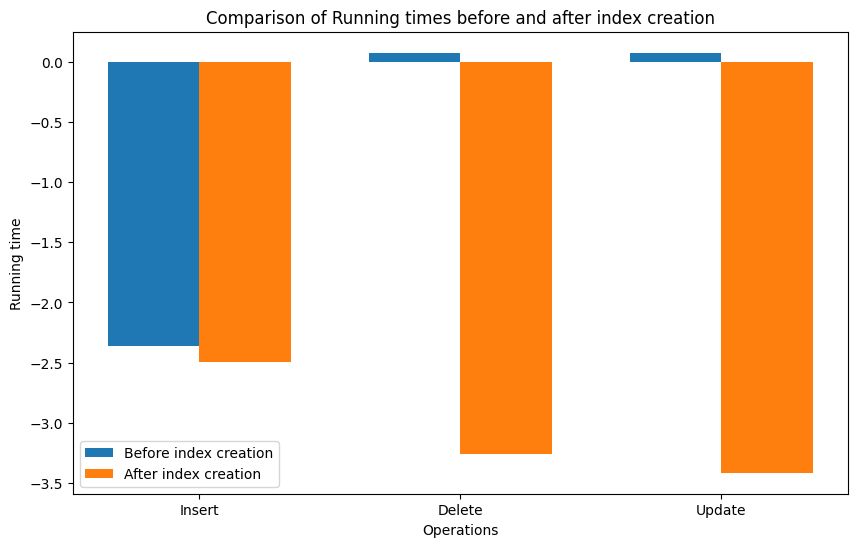

In [ ]:

import time

# Drop the index on the income field
cur.execute("DROP INDEX IF EXISTS idx_people_income")

# Drop the index on the name field
cur.execute("DROP INDEX IF EXISTS idx_people_name")

# Drop the index on the name and income field
cur.execute("DROP INDEX IF EXISTS idx_people_name_income")

# Drop the index on the name and income field
cur.execute("DROP INDEX IF EXISTS idx_people_name_income2")

# Drop the index on the name and income field
cur.execute("DROP INDEX IF EXISTS idx_people__name_income")

# Drop the index on the name and income field
cur.execute("DROP INDEX IF EXISTS idx_people_income_name")

# Calculate execution time
def calculate_execution_time(cur, query, params):
    start_time = time.time()
    cur.execute(query, params)
    conn.commit()
    #print("Final Query:", cur.mogrify(query, params))
    return time.time() - start_time

# Initialize time sums for insertions, deletions and updates
insert_time_before_indexes_sum = 0
delete_time_before_indexes_sum = 0
update_time_before_indexes_sum = 0

insert_time_after_indexes_sum = 0
delete_time_after_indexes_sum = 0
update_time_after_indexes_sum = 0

# Number of iterations
iterations = 100

# Insertion, deletion and update operations
insert_query = "INSERT INTO people (name, income) VALUES (%s, %s)"
delete_query = "DELETE FROM people WHERE name LIKE %s"
update_query = "UPDATE people SET income = income + 5000 WHERE name LIKE %s"

# Perform multiple insertions, deletions and updates before creating indexes
for i in range(iterations):
    insert_params = (f'John {i}', 50000 + i)
    delete_params = (f'J',)
    update_params = (f'J',)

    insert_time_before_indexes_sum += calculate_execution_time(cur, insert_query, insert_params)
    delete_time_before_indexes_sum += calculate_execution_time(cur, delete_query, delete_params)
    update_time_before_indexes_sum += calculate_execution_time(cur, update_query, update_params)

print("Average insertion time before indexes creation: ", insert_time_before_indexes_sum / iterations)
print("Average deletion time before indexes creation: ", delete_time_before_indexes_sum / iterations)
print("Average update time before indexes creation: ", update_time_before_indexes_sum / iterations)

# Create indexes on the name and income fields
cur.execute("CREATE INDEX idx_people_name ON people(name)")
cur.execute("CREATE INDEX idx_people_income ON people(income)")
cur.execute("CREATE INDEX idx_people_income_name ON people(name,income)")
cur.execute("CREATE INDEX idx_people__name_income ON people(income, name)")
conn.commit()

# Perform multiple insertions, deletions and updates after creating indexes
for i in range(iterations, 2*iterations):
    insert_params = (f'John {i}', 50000 + i)
    delete_params = (f'J',)
    update_params = (f'J',)

    insert_time_after_indexes_sum += calculate_execution_time(cur, insert_query, insert_params)
    delete_time_after_indexes_sum += calculate_execution_time(cur, delete_query, delete_params)
    update_time_after_indexes_sum += calculate_execution_time(cur, update_query, update_params)

print("Average insertion time after indexes creation: ", insert_time_after_indexes_sum / iterations)
print("Average deletion time after indexes creation: ", delete_time_after_indexes_sum / iterations)
print("Average update time after indexes creation: ", update_time_after_indexes_sum / iterations)
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function to calculate execution time using EXPLAIN ANALYZE
def calculate_execution_time(cur, query):
    cur.execute(f"EXPLAIN ANALYZE {query}")
    result = cur.fetchall()
    for row in result:
        if 'Execution Time' in row[0]:
            execution_time_str = row[0].split('Execution Time:')[1].strip()
            execution_time = float(execution_time_str.split(' ')[0])
            return execution_time
    return None
    
# Average running times
avg_insert_time_before_indexes = insert_time_before_indexes_sum / iterations
avg_delete_time_before_indexes = delete_time_before_indexes_sum / iterations
avg_update_time_before_indexes = update_time_before_indexes_sum / iterations

avg_insert_time_after_indexes = insert_time_after_indexes_sum / iterations
avg_delete_time_after_indexes = delete_time_after_indexes_sum / iterations
avg_update_time_after_indexes = update_time_after_indexes_sum / iterations

# Operations
operations = ['Insert', 'Delete', 'Update']

# Running times before and after index creation
running_times_before_indexes = [avg_insert_time_before_indexes, avg_delete_time_before_indexes, avg_update_time_before_indexes]
running_times_after_indexes = [avg_insert_time_after_indexes, avg_delete_time_after_indexes, avg_update_time_after_indexes]

# Convert the running times to log scale
log_running_times_before_indexes = np.log10(running_times_before_indexes)
log_running_times_after_indexes = np.log10(running_times_after_indexes)

x = np.arange(len(operations))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, log_running_times_before_indexes, width, label='Before index creation')
rects2 = ax.bar(x + width/2, log_running_times_after_indexes, width, label='After index creation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Operations')
ax.set_ylabel('Running time')
ax.set_title('Comparison of Running times before and after index creation')
ax.set_xticks(x)
ax.set_xticklabels(operations)
ax.legend()
plt.show()

